In [1]:
!pip install earth2studio[dlwp] earth2studio[pangu] earth2studio[sfno] earth2studio[cyclone] cartopy "makani @ git+https://github.com/NVIDIA/modulus-makani.git@28f38e3e929ed1303476518552c64673bbd6f722"

# !git clone https://github.com/NVIDIA/makani.git
# %cd makani
# !pip install -e .
# %cd ..


  Using cached makani-0.2.0-py3-none-any.whl


In [36]:
import numpy as np
import xarray as xr
import torch
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

from tqdm import tqdm

from earth2studio.models.px import SFNO
from earth2studio.models.dx import TCTrackerWuDuan, TCTrackerVitart
from earth2studio.data import GFS, ARCO, fetch_data, prep_data_array
from earth2studio.utils.time import to_time_array
from earth2studio.utils.coords import map_coords
import logging

logging.getLogger("earth2studio.data").setLevel(logging.WARNING)

# ---- device ----
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available – check your WSL2/NVIDIA setup")
device = torch.device("cuda:0")

# ---- models ----
sfno = SFNO.load_model(SFNO.load_default_package()).to(device)

tc_tracker = TCTrackerWuDuan().to(device)

# ---- data sources ----
gfs = GFS()
era5 = ARCO()




In [22]:
def get_initial_state(model, data_source, start_times, device):
    """
    Fetch and map initial condition to the model's prognostic grid.
    start_times: list of ISO strings, e.g. ["2017-08-25T00:00"]
    """
    prognostic_ic = model.input_coords()
    time = to_time_array(start_times)

    x0, coords0 = fetch_data(
        source=data_source,
        time=time,
        variable=prognostic_ic["variable"],
        lead_time=prognostic_ic["lead_time"],
        device=device,
        interp_to=prognostic_ic if hasattr(model, "interp_method") else None,
        interp_method=getattr(model, "interp_method", "nearest"),
    )

    x0, coords0 = map_coords(x0, coords0, prognostic_ic)
    return x0, coords0


def integrate_model(model, x_init, coords_init, nsteps: int, include_init: bool = True):
    """
    Run the model iterator and return:
      - xs: list of tensors on CPU
      - coords_list: list of coord dicts

    If include_init=True:
      xs = [x^0, x^1, ..., x^nsteps]  (length nsteps+1)
      coords_list = [coords^0, coords^1, ..., coords^nsteps]

      where x^0, coords^0 are the initial condition you passed in.

    If include_init=False:
      xs = [x^1, ..., x^nsteps]       (length nsteps)
    """
    xs = []
    coords_list = []

    # optionally store the initial state as step 0
    if include_init:
        xs.append(x_init.detach().cpu())
        coords_list.append(coords_init)

    it = model.create_iterator(x_init.clone(), coords_init)

    # we still want exactly nsteps model advances
    # so that total length is nsteps+1 when include_init=True
    for step, (x_step, coords_step) in enumerate(it, start=1 if include_init else 0):
        xs.append(x_step.detach().cpu())
        coords_list.append(coords_step)
        if step == nsteps:
            break

    return xs, coords_list


def apply_box_perturbation(
    x_init,
    coords,
    target_var: str,
    delta: float,
    lat_range,
    lon_range,
):
    """
    Add 'delta' to target_var in a lat/lon box.
    lat_range, lon_range: (min, max)
    Returns a new tensor on the same device as x_init.
    """
    dim_names = list(coords.keys())  # e.g. ["time", "lead_time", "variable", "lat", "lon"]
    axis = {name: i for i, name in enumerate(dim_names)}

    var_names = np.array(coords["variable"])
    lat = np.array(coords["lat"])
    lon = np.array(coords["lon"])

    var_idx = int(np.where(var_names == target_var)[0][0])
    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = (lon >= lon_min) & (lon <= lon_max)

    x_np = x_init.detach().cpu().numpy()

    lat_idx = np.where(lat_mask)[0]
    lon_idx = np.where(lon_mask)[0]
    lat_ix, lon_ix = np.ix_(lat_idx, lon_idx)

    idx = [slice(None)] * x_np.ndim
    idx[axis["variable"]] = var_idx
    idx[axis["lat"]] = lat_ix
    idx[axis["lon"]] = lon_ix

    x_np_pert = x_np.copy()
    x_np_pert[tuple(idx)] += delta

    return torch.from_numpy(x_np_pert).to(x_init.device)


def build_sequence_da(
    ctrl_steps,
    coords0,
    step_hours: int,
    pert_steps=None,
    name_ctrl="control",
    name_pert="perturbed",
):
    """
    Turn lists of tensors into xarray DataArrays:
    x_ctrl, x_pert, x_diff (latter two may be None if pert_steps is None).
    """
    ctrl_np = np.stack([t.numpy() for t in ctrl_steps], axis=0)  # (step, ...)

    dim_names = list(coords0.keys())
    coords_for_xr = {name: np.array(coords0[name]) for name in dim_names}

    n_steps = ctrl_np.shape[0]
    step_vals = np.arange(n_steps)
    lead_hours = step_hours * step_vals

    coords_full = {
        "step": step_vals,
        "lead_hours": ("step", lead_hours),
    }
    coords_full.update(coords_for_xr)

    x_ctrl = xr.DataArray(
        ctrl_np,
        dims=("step",) + tuple(dim_names),
        coords=coords_full,
        name=name_ctrl,
    )

    if pert_steps is None:
        return x_ctrl, None, None

    pert_np = np.stack([t.numpy() for t in pert_steps], axis=0)
    x_pert = xr.DataArray(
        pert_np,
        dims=("step",) + tuple(dim_names),
        coords=coords_full,
        name=name_pert,
    )

    x_diff = x_pert - x_ctrl
    x_diff.name = f"{name_pert}_minus_{name_ctrl}"

    return x_ctrl, x_pert, x_diff


In [20]:
def plot_forecast_sequence(
    x_ctrl,
    target_var: str,
    x_pert=None,
    x_diff=None,
    steps_to_show=None,
):
    """
    If x_pert/x_diff provided:
      - plot RMS growth vs lead time
      - for each chosen step: control / perturbed / difference maps

    If only x_ctrl provided:
      - plot the control map over time (single panel per step).
    """
    ctrl_var = x_ctrl.sel(variable=target_var).isel(time=0, lead_time=0)

    lead_hours = x_ctrl["lead_hours"].values

    if steps_to_show is None:
        steps_to_show = range(ctrl_var.sizes["step"])

    # If perturbed forecast is provided, plot RMS and triptychs
    if x_pert is not None and x_diff is not None:
        pert_var = x_pert.sel(variable=target_var).isel(time=0, lead_time=0)
        diff_var = x_diff.sel(variable=target_var).isel(time=0, lead_time=0)

        rms_by_step = np.sqrt((diff_var ** 2).mean(dim=("lat", "lon")))

        plt.figure(figsize=(8, 4))
        rms_by_step.plot(x="lead_hours", marker="o")
        plt.xlabel("Lead time (hours)")
        plt.ylabel(f"RMS difference in {target_var}")
        plt.title(f"Growth of perturbation in {target_var}")
        plt.grid(True)
        plt.show()

        for k in steps_to_show:
            ctrl_k = ctrl_var.sel(step=k)
            pert_k = pert_var.sel(step=k)
            diff_k = diff_var.sel(step=k)

            fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

            ctrl_k.plot(ax=axs[0], x="lon", y="lat")
            axs[0].set_title(f"Control {target_var}, +{int(lead_hours[k])} h")

            pert_k.plot(ax=axs[1], x="lon", y="lat")
            axs[1].set_title(f"Perturbed {target_var}, +{int(lead_hours[k])} h")

            diff_k.plot(ax=axs[2], x="lon", y="lat")
            axs[2].set_title(f"Difference, +{int(lead_hours[k])} h")

            plt.show()

    # If no perturbed forecast, just show control maps
    else:
        for k in steps_to_show:
            ctrl_k = ctrl_var.sel(step=k)

            fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
            ctrl_k.plot(ax=ax, x="lon", y="lat")
            ax.set_title(f"{target_var}, +{int(lead_hours[k])} h (control)")
            plt.show()


In [12]:
def run_tc_on_reanalysis(tc_model, data_source, start_time, nsteps, device):
    """
    Run TC tracker directly on a data source (e.g. ERA5 via ARCO or GFS).
    Returns the final output tensor (same thing you were calling `output`),
    moved to CPU.
    """
    tc_model.reset_path_buffer()

    times = [start_time + timedelta(hours=6 * i) for i in range(nsteps + 1)]
    for step, t in enumerate(times):
        da = data_source(t, tc_model.input_coords()["variable"])
        x, coords = prep_data_array(da, device=device)
        output, output_coords = tc_model(x, coords)
        # you were just printing shapes per step; last 'output' carries tracks
        print(f"Step {step}: {data_source.__class__.__name__} tracks output shape {output.shape}")

    return output.detach().cpu()


def run_tc_on_forecast(tc_model, forecast_steps, forecast_coords, device):
    """
    Run TC tracker on a SFNO forecast sequence:
      forecast_steps: list of CPU tensors (from integrate_model)
      forecast_coords: list of coords dicts (same length)
    Returns final output tensor with tracks on CPU.
    """
    tc_model.reset_path_buffer()

    for step, (x_cpu, coords) in enumerate(zip(forecast_steps, forecast_coords)):
        x = x_cpu.to(device)
        x_tc, coords_tc = map_coords(x, coords, tc_model.input_coords())
        output, output_coords = tc_model(x_tc, coords_tc)
        # remove lead_time dim (as you did: output = output[:, 0])
        output = output[:, 0]
        print(f"Step {step}: forecast tracks output shape {output.shape}")

    return output.detach().cpu()


In [40]:
def _tracks_to_numpy(tracks):
    """Normalize torch.Tensor or array-like to a NumPy array."""
    if isinstance(tracks, torch.Tensor):
        return tracks.detach().cpu().numpy()
    return np.asarray(tracks)


def plot_tc_tracks(
    tracks1,
    tracks2=None,
    labels=("Run 1", "Run 2"),
    region=(-180, 180, -90, 90),
    start_time=None,
    step_hours=6,
    nsteps=None,
    cmap1=plt.cm.autumn,
    cmap2=plt.cm.winter,
):
    """
    Plot cyclone tracks for one or two runs on a single map.

    Visualization:
      • tracks1 = solid lines (default)
      • tracks2 = X markers only (no solid line), so overlaps are visible
    """
    tracks1_np = _tracks_to_numpy(tracks1)
    tracks2_np = _tracks_to_numpy(tracks2) if tracks2 is not None else None

    lon_min, lon_max, lat_min, lat_max = region

    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(
        1, 1,
        figsize=(10, 8),
        subplot_kw={"projection": projection},
    )

    # Base map
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.gridlines(draw_labels=True, alpha=0.6)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # ---- Plot tracks1 (solid lines) ----
    n1 = tracks1_np.shape[1]
    for path in range(n1):
        lats = tracks1_np[0, path, :, 0]
        lons = tracks1_np[0, path, :, 1]
        mask = ~np.isnan(lats) & ~np.isnan(lons)
        if mask.any() and len(lons[mask]) > 2:
            color = cmap1(path / max(1, n1))
            ax.plot(
                lons[mask],
                lats[mask],
                color=color,
                linewidth=2.0,
                linestyle="-",
                transform=ccrs.PlateCarree(),
                label=labels[0] if path == 0 else None,
            )

    # ---- Plot tracks2 (X markers only, no solid line) ----
    if tracks2_np is not None:
        n2 = tracks2_np.shape[1]
        for path in range(n2):
            lats = tracks2_np[0, path, :, 0]
            lons = tracks2_np[0, path, :, 1]
            mask = ~np.isnan(lats) & ~np.isnan(lons)
            if mask.any() and len(lons[mask]) > 2:
                color = cmap2(path / max(1, n2))

                # KEY CHANGE:
                # marker 'x', no connecting line
                ax.plot(
                    lons[mask],
                    lats[mask],
                    color=color,
                    marker="x",
                    markersize=6,
                    linestyle="",
                    transform=ccrs.PlateCarree(),
                    label=labels[1] if path == 0 else None,
                )

    # Legend
    handles = []
    handles.append(mpatches.Patch(color=cmap1(0.5), label=labels[0]))
    if tracks2_np is not None:
        handles.append(mpatches.Patch(color=cmap2(0.5), label=labels[1]))

    ax.legend(handles=handles, loc="upper right", title="Cyclone Runs")

    # Title
    if start_time is not None and nsteps is not None:
        end_time = start_time + timedelta(hours=step_hours * nsteps)
        ax.set_title(
            f"Cyclone Track Comparison\n{start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')}"
        )

    plt.tight_layout()
    plt.show()


Fetching ARCO data:   0%|          | 0/73 [00:00<?, ?it/s]

2025-12-04 23:08:01.319 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: tcwv at 2005-08-25T00:00:00
2025-12-04 23:08:01.321 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-25T00:00:00
2025-12-04 23:08:01.323 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v925 at 2005-08-25T00:00:00
2025-12-04 23:08:01.326 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-25T00:00:00
2025-12-04 23:08:01.328 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u200 at 2005-08-25T00:00:00
2025-12-04 23:08:01.331 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: q250 at 2005-08-25T00:00:00
2025-12-04 23:08:01.332 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: q400 at 2005-0

Fetching ARCO data:   1%|▏         | 1/73 [00:02<02:22,  1.97s/it]

2025-12-04 23:08:03.304 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/926088.0.0.0 to local cache
2025-12-04 23:08:03.308 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/specific_humidity/926088.0.0.0 to local cache
2025-12-04 23:08:03.312 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/926088.0.0.0 to local cache
2025-12-04 23:08:03.316 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/926088.0.0.0 to local cache
2025-12-04 23:08:03.320 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/926088.0.0.0 to loca

Fetching ARCO data:   1%|▏         | 1/73 [00:02<02:22,  1.97s/it]

2025-12-04 23:08:03.615 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/geopotential/926088.0.0.0 to local cache
2025-12-04 23:08:03.618 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/temperature/926088.0.0.0 to local cache
2025-12-04 23:08:03.621 | DEBUG    | earth2studio.data.utils:_make_local_details:657 - Copying /gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3/total_column_water_vapour/926088.0.0 to local cache


Fetching ARCO data: 100%|██████████| 73/73 [00:14<00:00,  4.87it/s]


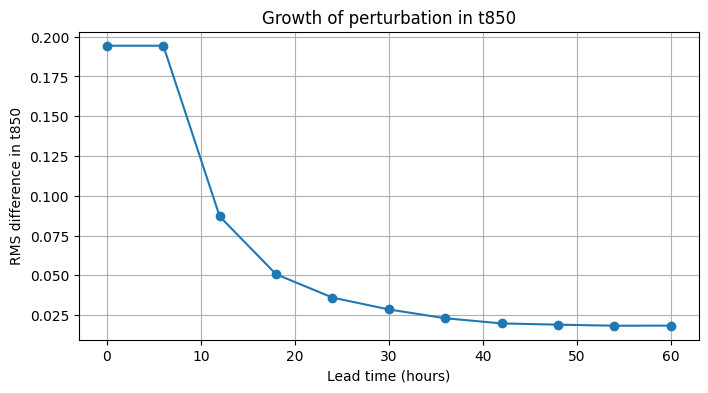

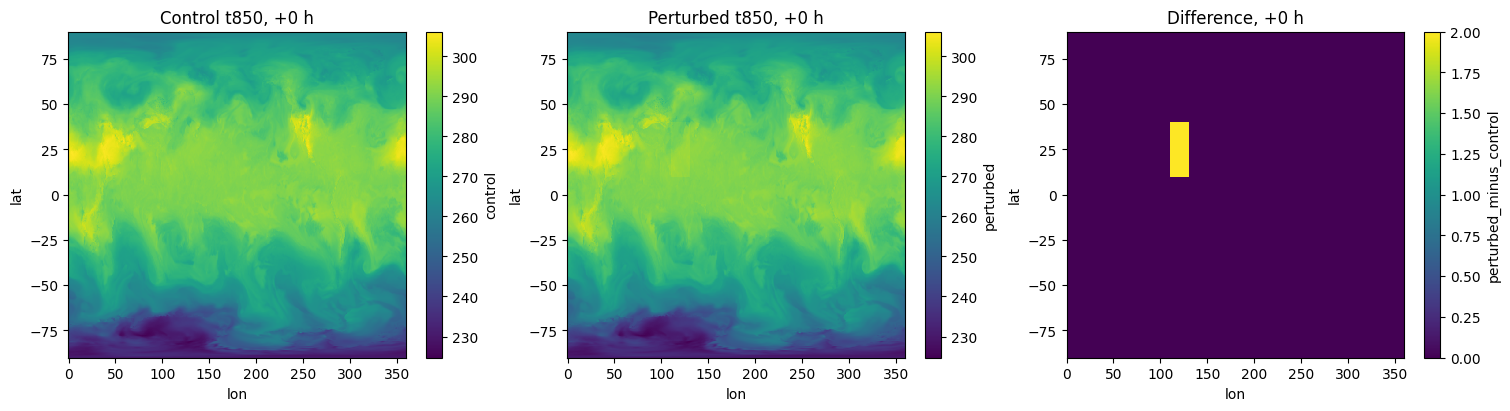

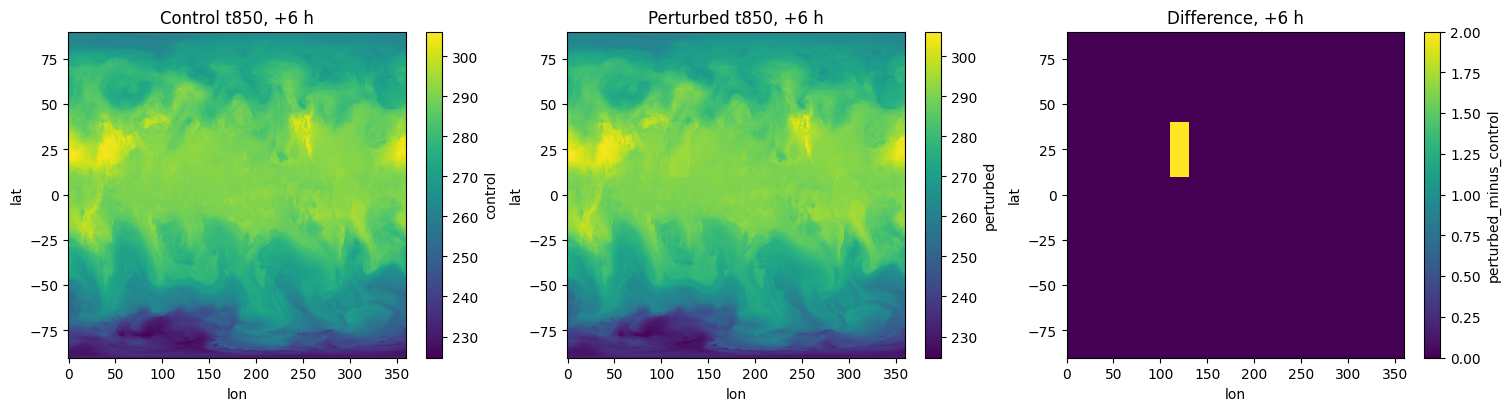

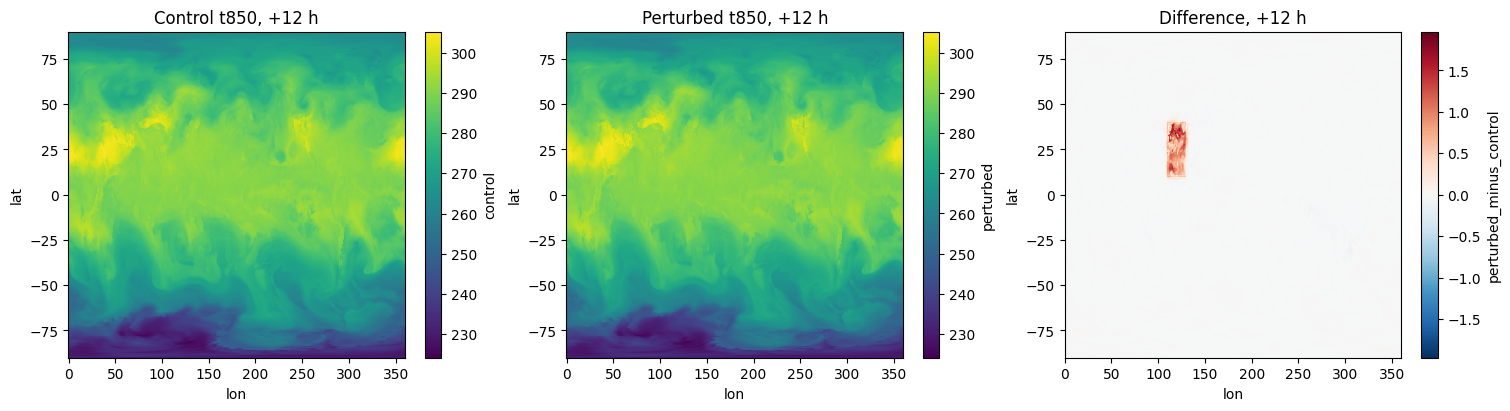

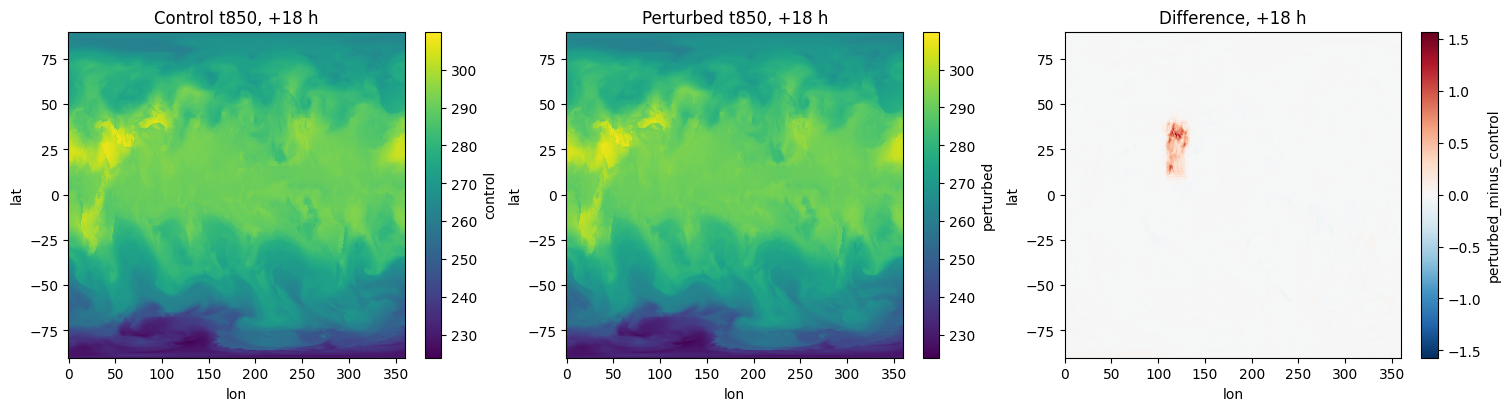

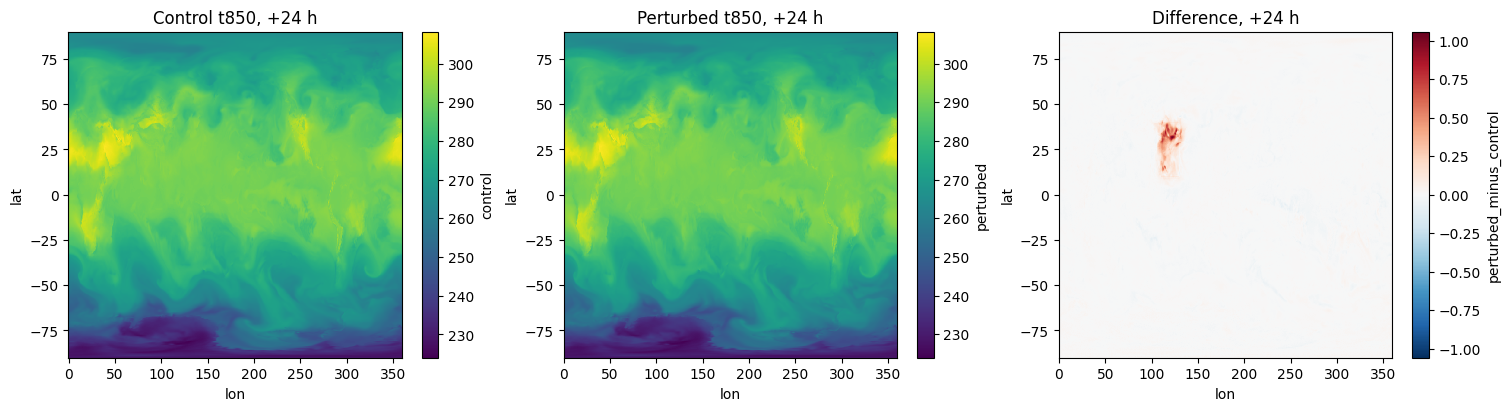

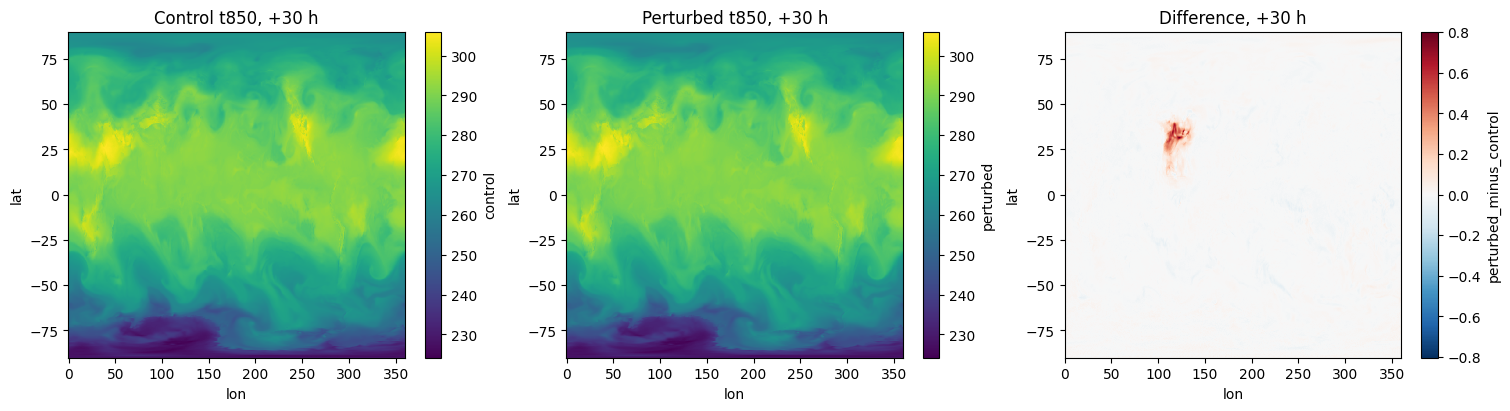

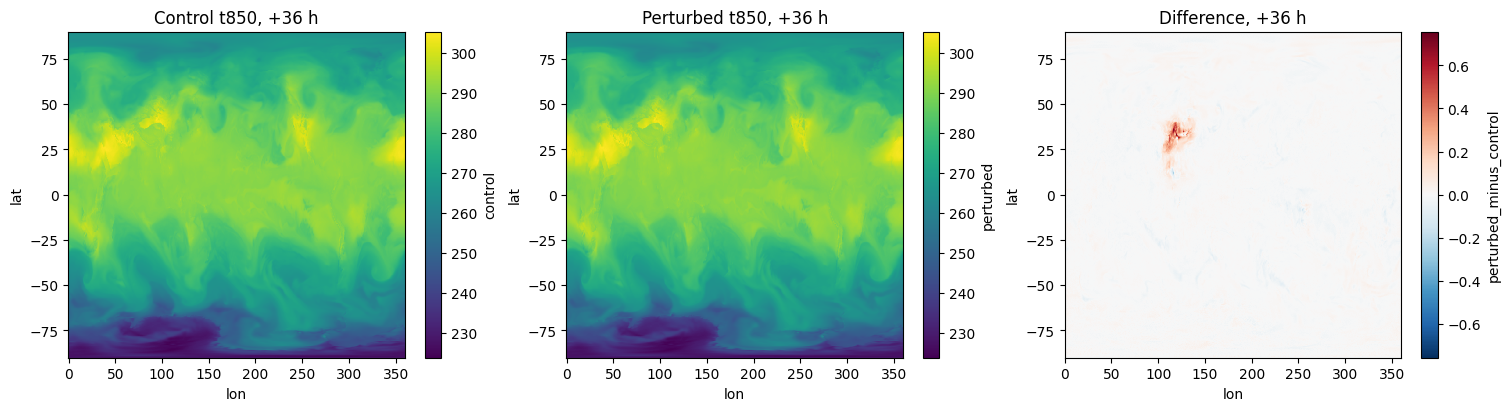

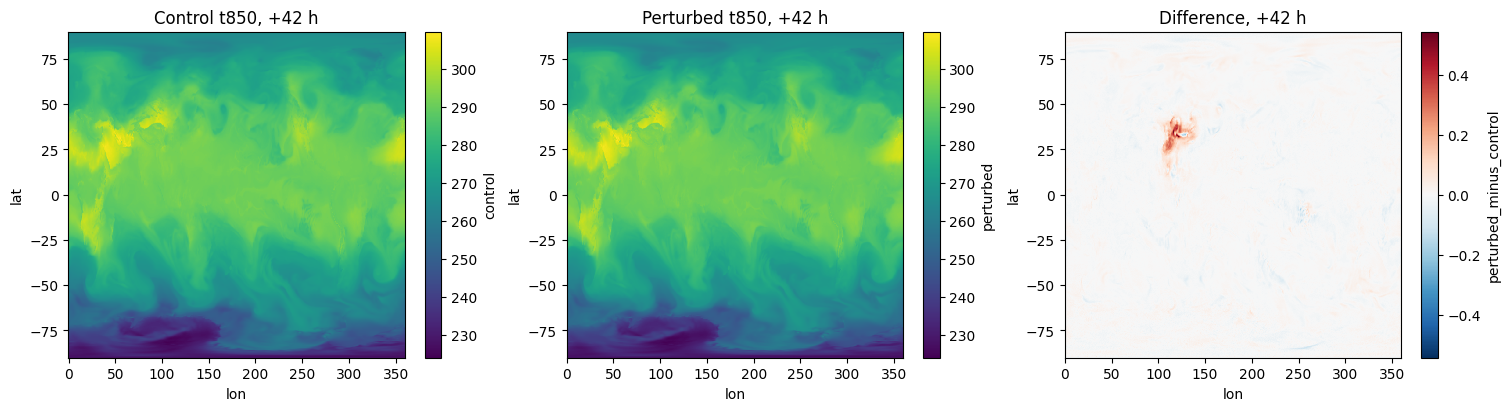

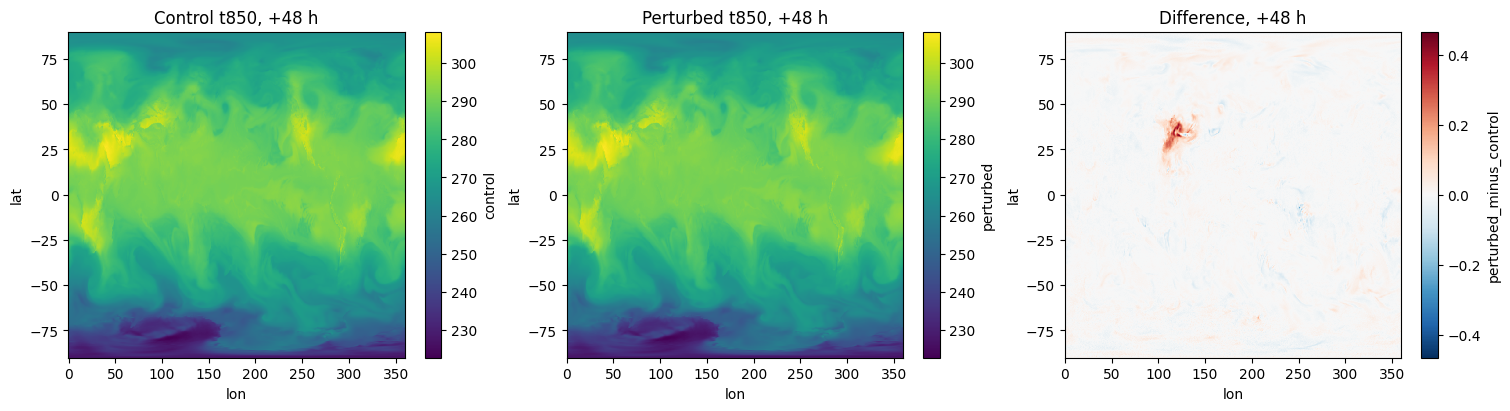

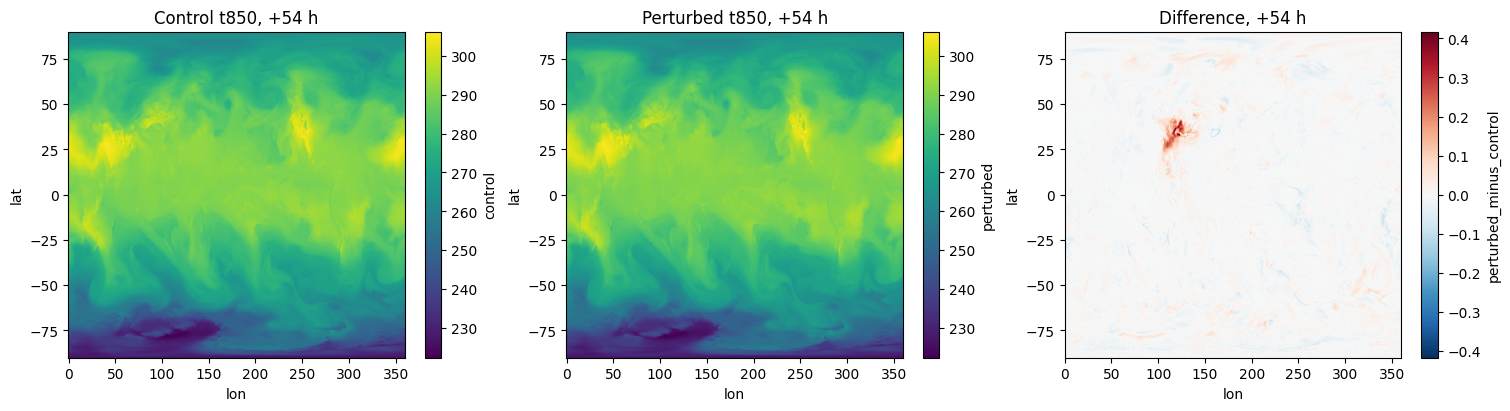

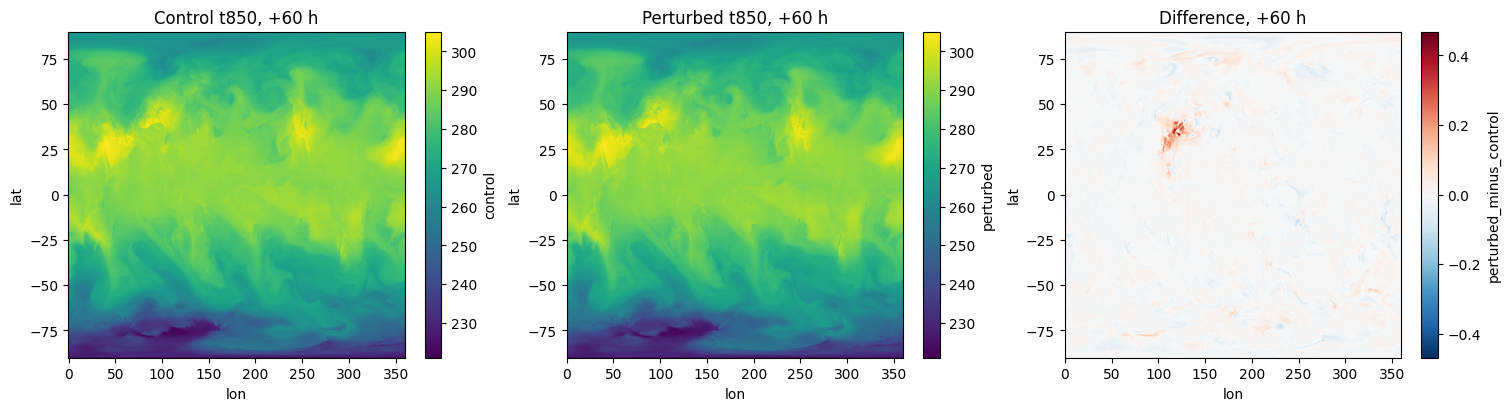

In [32]:
# --- forecast setup ---
start_time = datetime(2005, 8, 25)
start_times = [start_time.isoformat()]
nsteps = 10           # 10 steps -> 60 h for SFNO (6 h per step)
step_hours = 6

x0, coords0 = get_initial_state(sfno, era5, start_times, device)

# control forecast
ctrl_steps, ctrl_coords = integrate_model(sfno, x0, coords0, nsteps)

# perturbed initial condition
x_pert = apply_box_perturbation(
    x0,
    coords0,
    target_var="t850",
    delta=2.0,
    lat_range=(10, 40),
    lon_range=(110, 130),
)

pert_steps, pert_coords = integrate_model(sfno, x_pert, coords0, nsteps)

# build xarray views & plot
x_ctrl, x_pert_da, x_diff = build_sequence_da(
    ctrl_steps,
    coords0,
    step_hours=step_hours,
    pert_steps=pert_steps,
    name_ctrl="control",
    name_pert="perturbed",
)

plot_forecast_sequence(
    x_ctrl,
    target_var="t850",
    x_pert=x_pert_da,
    x_diff=x_diff,
    steps_to_show=range(0, nsteps + 1, 1),
)


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:07.493 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-25T00:00:00
2025-12-04 23:17:07.495 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-25T00:00:00
2025-12-04 23:17:07.497 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-25T00:00:00
2025-12-04 23:17:07.499 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-25T00:00:00
2025-12-04 23:17:07.502 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-25T00:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 22.61it/s]


Step 0: ARCO tracks output shape torch.Size([1, 5, 1, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:08.123 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-25T06:00:00
2025-12-04 23:17:08.125 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-25T06:00:00
2025-12-04 23:17:08.128 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-25T06:00:00
2025-12-04 23:17:08.130 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-25T06:00:00
2025-12-04 23:17:08.132 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-25T06:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.46it/s]


Step 1: ARCO tracks output shape torch.Size([1, 6, 2, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:08.743 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-25T12:00:00
2025-12-04 23:17:08.746 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-25T12:00:00
2025-12-04 23:17:08.748 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-25T12:00:00
2025-12-04 23:17:08.750 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-25T12:00:00
2025-12-04 23:17:08.753 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-25T12:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.42it/s]


Step 2: ARCO tracks output shape torch.Size([1, 7, 3, 4])


Fetching ARCO data:  80%|████████  | 4/5 [00:00<00:00, 20.34it/s]

2025-12-04 23:17:09.337 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-25T18:00:00
2025-12-04 23:17:09.339 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-25T18:00:00
2025-12-04 23:17:09.341 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-25T18:00:00
2025-12-04 23:17:09.343 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-25T18:00:00
2025-12-04 23:17:09.345 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-25T18:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.95it/s]


Step 3: ARCO tracks output shape torch.Size([1, 8, 4, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:09.943 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-26T00:00:00
2025-12-04 23:17:09.946 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-26T00:00:00
2025-12-04 23:17:09.948 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-26T00:00:00
2025-12-04 23:17:09.951 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-26T00:00:00
2025-12-04 23:17:09.953 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-26T00:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.79it/s]


Step 4: ARCO tracks output shape torch.Size([1, 9, 5, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:10.568 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-26T06:00:00
2025-12-04 23:17:10.570 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-26T06:00:00
2025-12-04 23:17:10.573 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-26T06:00:00
2025-12-04 23:17:10.575 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-26T06:00:00
2025-12-04 23:17:10.577 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-26T06:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 22.55it/s]


Step 5: ARCO tracks output shape torch.Size([1, 10, 6, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:11.214 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-26T12:00:00
2025-12-04 23:17:11.217 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-26T12:00:00
2025-12-04 23:17:11.219 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-26T12:00:00
2025-12-04 23:17:11.221 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-26T12:00:00
2025-12-04 23:17:11.224 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-26T12:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.53it/s]


Step 6: ARCO tracks output shape torch.Size([1, 11, 7, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:11.814 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-26T18:00:00
2025-12-04 23:17:11.816 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-26T18:00:00
2025-12-04 23:17:11.818 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-26T18:00:00
2025-12-04 23:17:11.821 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-26T18:00:00
2025-12-04 23:17:11.822 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-26T18:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.71it/s]


Step 7: ARCO tracks output shape torch.Size([1, 12, 8, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:12.501 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-27T00:00:00
2025-12-04 23:17:12.503 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-27T00:00:00
2025-12-04 23:17:12.505 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-27T00:00:00
2025-12-04 23:17:12.508 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-27T00:00:00
2025-12-04 23:17:12.510 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-27T00:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.36it/s]


Step 8: ARCO tracks output shape torch.Size([1, 13, 9, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:13.157 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-27T06:00:00
2025-12-04 23:17:13.159 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-27T06:00:00
2025-12-04 23:17:13.162 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-27T06:00:00
2025-12-04 23:17:13.164 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-27T06:00:00
2025-12-04 23:17:13.166 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-27T06:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.20it/s]


Step 9: ARCO tracks output shape torch.Size([1, 14, 10, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:13.759 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-27T12:00:00
2025-12-04 23:17:13.762 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-27T12:00:00
2025-12-04 23:17:13.764 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-27T12:00:00
2025-12-04 23:17:13.766 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-27T12:00:00
2025-12-04 23:17:13.768 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-27T12:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.75it/s]


Step 10: ARCO tracks output shape torch.Size([1, 15, 11, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:14.351 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-27T18:00:00
2025-12-04 23:17:14.353 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-27T18:00:00
2025-12-04 23:17:14.356 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-27T18:00:00
2025-12-04 23:17:14.358 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-27T18:00:00
2025-12-04 23:17:14.361 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-27T18:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.68it/s]


Step 11: ARCO tracks output shape torch.Size([1, 16, 12, 4])


Fetching ARCO data:  80%|████████  | 4/5 [00:00<00:00, 20.44it/s]

2025-12-04 23:17:14.921 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-28T00:00:00
2025-12-04 23:17:14.923 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-28T00:00:00
2025-12-04 23:17:14.926 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-28T00:00:00
2025-12-04 23:17:14.928 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-28T00:00:00
2025-12-04 23:17:14.931 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-28T00:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 24.03it/s]


Step 12: ARCO tracks output shape torch.Size([1, 17, 13, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:15.506 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-28T06:00:00
2025-12-04 23:17:15.509 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-28T06:00:00
2025-12-04 23:17:15.511 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-28T06:00:00
2025-12-04 23:17:15.514 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-28T06:00:00
2025-12-04 23:17:15.516 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-28T06:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Step 13: ARCO tracks output shape torch.Size([1, 18, 14, 4])


Fetching ARCO data:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-04 23:17:16.102 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-28T12:00:00
2025-12-04 23:17:16.105 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-28T12:00:00
2025-12-04 23:17:16.107 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-28T12:00:00
2025-12-04 23:17:16.109 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-28T12:00:00
2025-12-04 23:17:16.112 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-28T12:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.61it/s]


Step 14: ARCO tracks output shape torch.Size([1, 18, 15, 4])


Fetching ARCO data:  80%|████████  | 4/5 [00:00<00:00, 20.40it/s]

2025-12-04 23:17:16.665 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-28T18:00:00
2025-12-04 23:17:16.668 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-28T18:00:00
2025-12-04 23:17:16.670 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-28T18:00:00
2025-12-04 23:17:16.672 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-28T18:00:00
2025-12-04 23:17:16.675 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-28T18:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 24.02it/s]


Step 15: ARCO tracks output shape torch.Size([1, 19, 16, 4])


Fetching ARCO data:  80%|████████  | 4/5 [00:00<00:00, 20.22it/s]

2025-12-04 23:17:17.224 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u850 at 2005-08-29T00:00:00
2025-12-04 23:17:17.227 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v10m at 2005-08-29T00:00:00
2025-12-04 23:17:17.229 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: u10m at 2005-08-29T00:00:00
2025-12-04 23:17:17.231 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: v850 at 2005-08-29T00:00:00
2025-12-04 23:17:17.234 | DEBUG    | earth2studio.data.arco:fetch_array:289 - Fetching ARCO zarr array for variable: msl at 2005-08-29T00:00:00


Fetching ARCO data: 100%|██████████| 5/5 [00:00<00:00, 23.76it/s]


Step 16: ARCO tracks output shape torch.Size([1, 20, 17, 4])
Step 0: forecast tracks output shape torch.Size([1, 5, 1, 4])
Step 1: forecast tracks output shape torch.Size([1, 5, 2, 4])
Step 2: forecast tracks output shape torch.Size([1, 6, 3, 4])
Step 3: forecast tracks output shape torch.Size([1, 7, 4, 4])
Step 4: forecast tracks output shape torch.Size([1, 8, 5, 4])
Step 5: forecast tracks output shape torch.Size([1, 9, 6, 4])
Step 6: forecast tracks output shape torch.Size([1, 10, 7, 4])
Step 7: forecast tracks output shape torch.Size([1, 11, 8, 4])
Step 8: forecast tracks output shape torch.Size([1, 12, 9, 4])
Step 9: forecast tracks output shape torch.Size([1, 13, 10, 4])
Step 10: forecast tracks output shape torch.Size([1, 14, 11, 4])
Step 0: forecast tracks output shape torch.Size([1, 5, 1, 4])
Step 1: forecast tracks output shape torch.Size([1, 5, 2, 4])
Step 2: forecast tracks output shape torch.Size([1, 6, 3, 4])
Step 3: forecast tracks output shape torch.Size([1, 7, 4, 4])
S

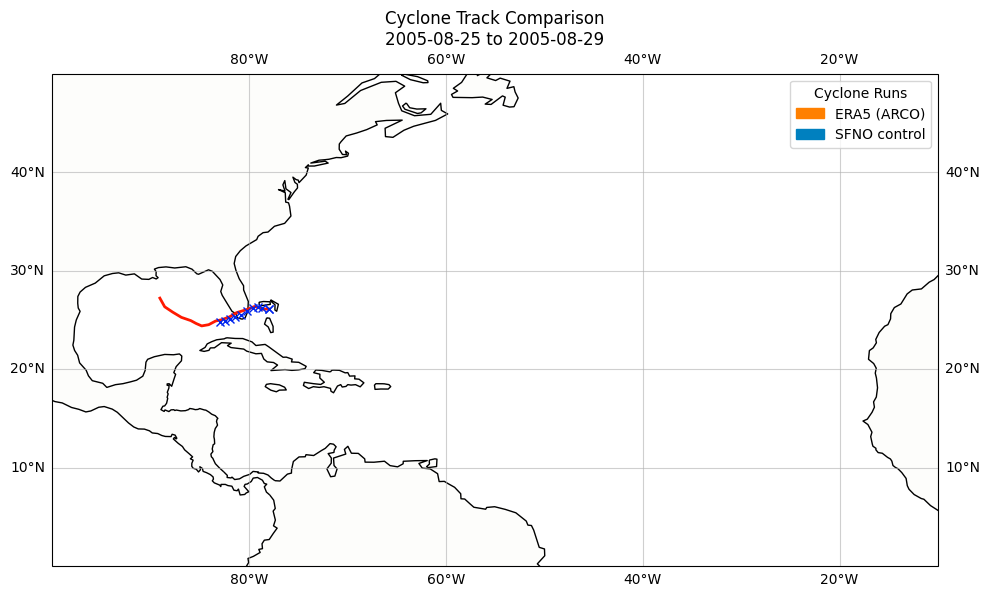

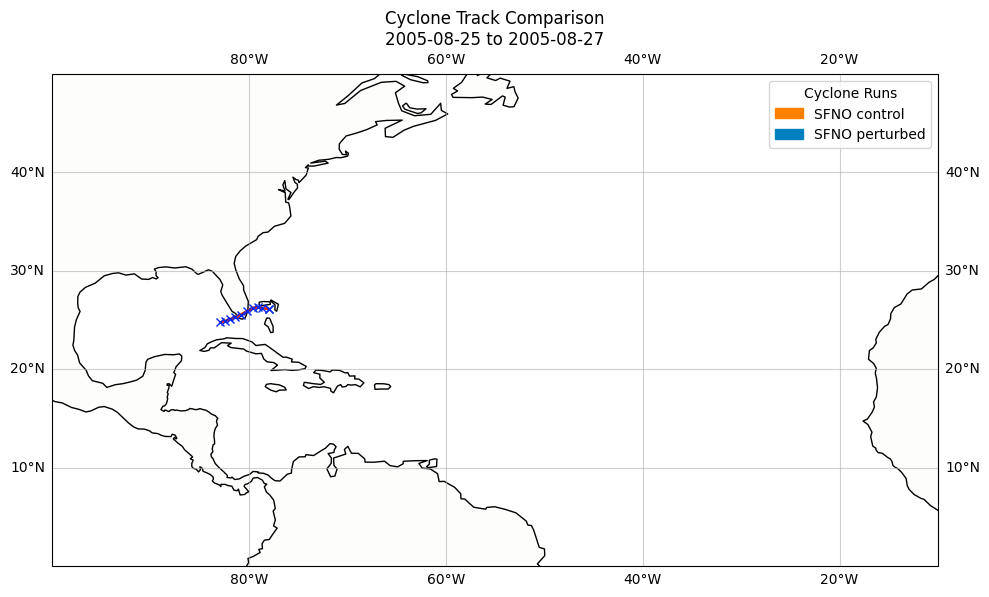

In [43]:
# --- TC tracker on ERA5 (ARCO) ---
nsteps_tc = 16
# tc_start = datetime(2009, 8, 5)
tc_start = start_time

era5_tracks = run_tc_on_reanalysis(
    tc_model=tc_tracker,
    data_source=era5,   # or gfs if you want GFS
    start_time=tc_start,
    nsteps=nsteps_tc,
    device=device,
)

# --- TC tracker on control forecast ---
sfno_ctrl_tracks = run_tc_on_forecast(
    tc_model=tc_tracker,
    forecast_steps=ctrl_steps,
    forecast_coords=ctrl_coords,
    device=device,
)

# --- TC tracker on perturbed forecast ---
sfno_pert_tracks = run_tc_on_forecast(
    tc_model=tc_tracker,
    forecast_steps=pert_steps,
    forecast_coords=pert_coords,
    device=device,
)

# --- plot comparisons ---
# ERA5 vs SFNO control
plot_tc_tracks(
    era5_tracks,
    sfno_ctrl_tracks,
    labels=("ERA5 (ARCO)", "SFNO control"),
    region=(-100, -10, 0, 50),
    start_time=tc_start,
    step_hours=step_hours,
    nsteps=nsteps_tc,
)

# SFNO control vs SFNO perturbed
plot_tc_tracks(
    sfno_ctrl_tracks,
    sfno_pert_tracks,
    labels=("SFNO control", "SFNO perturbed"),
    region=(-100, -10, 0, 50),
    start_time=start_time,
    step_hours=step_hours,
    nsteps=nsteps,
)
